In [132]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from torch.utils.data import DataLoader

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


data_path = '/content/gdrive/MyDrive/data.csv'

data = pd.read_csv(data_path)

# drop last column (extra column added by pd)
# and unnecessary first column (id)
data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

print("applying feature engineering...")
# convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': 0.0}
data['diagnosis'] = data['diagnosis'].map(diag_map)

# put features & outputs in different data frames
Y = data.loc[:, 'diagnosis']
X = data.iloc[:, 1:]

# filter features
remove_correlated_features(X)
remove_less_significant_features(X, Y)

# normalize data for better convergence and to prevent overflow
X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

# insert 1 in every row for intercept b
X.insert(loc=len(X.columns), column='intercept', value=1)

# split data into train and test set
print("splitting dataset into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape



Mounted at /content/gdrive
applying feature engineering...
splitting dataset into train and test sets...


Epoch: 100, Train Loss: 0.6683, Val Loss: 0.6695
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 200, Train Loss: 0.6414, Val Loss: 0.6419
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 300, Train Loss: 0.6176, Val Loss: 0.6167
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 400, Train Loss: 0.5941, Val Loss: 0.5918
accuracy: 0.6461538461538462, val accuracy: 0.6578947368421053
Epoch: 500, Train Loss: 0.5703, Val Loss: 0.5665
accuracy: 0.6901098901098901, val accuracy: 0.7105263157894737
Epoch: 600, Train Loss: 0.5461, Val Loss: 0.5409
accuracy: 0.7428571428571429, val accuracy: 0.7543859649122807
Epoch: 700, Train Loss: 0.5216, Val Loss: 0.5149
accuracy: 0.8021978021978022, val accuracy: 0.8157894736842105
Epoch: 800, Train Loss: 0.4969, Val Loss: 0.4888
accuracy: 0.8263736263736263, val accuracy: 0.8245614035087719
Epoch: 900, Train Loss: 0.4725, Val Loss: 0.4631
accuracy: 0.8483516483516483, val accuracy: 0.850877192

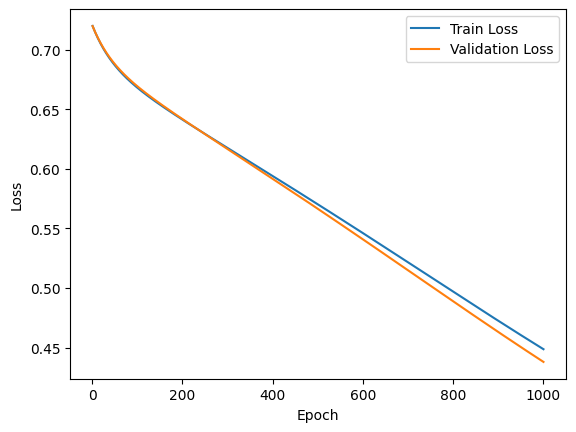

In [155]:
class Net(nn.Module):
  """
  Simple 1 hidden layer neural net
  """

  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return F.sigmoid(out)

# Define the training loop

def training_loop(n_epochs, optimizer, model, loss_fn, X_train, X_val,
                  y_train, y_val):

  train_losses = []
  val_losses = []

  for epoch in range(1, n_epochs+1):
    # Training
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)

    # Reshape y_train to match the shape of y_pred
    y_train = y_train.view(-1, 1)
    y_val = y_val.view(-1, 1)

    # Calculate accuracy
    predictions = (y_pred > 0.5).float()
    correct = (predictions == y_train).sum().item()
    accuracy = correct / y_train.size(0)

    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

        # Calculate accuracy
        val_predictions = (y_val_pred > 0.5).float()
        val_correct = (val_predictions == y_val).sum().item()
        val_accuracy = val_correct / y_val.size(0)

        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        print(f'accuracy: {accuracy}, val accuracy: {val_accuracy}')

  # Plotting
  plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
  plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()



# Input, hidden, and output sizes
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

model = Net(input_size, hidden_size, output_size)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

training_loop(1000, optimizer, model, loss_fn, X_train_tensor, X_test_tensor,
                  y_train_tensor, y_test_tensor)

Epoch: 100, Train Loss: 0.6593, Val Loss: 0.6604
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 200, Train Loss: 0.6417, Val Loss: 0.6431
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 300, Train Loss: 0.6239, Val Loss: 0.6249
accuracy: 0.6285714285714286, val accuracy: 0.6228070175438597
Epoch: 400, Train Loss: 0.6028, Val Loss: 0.6030
accuracy: 0.6417582417582418, val accuracy: 0.631578947368421
Epoch: 500, Train Loss: 0.5765, Val Loss: 0.5757
accuracy: 0.6747252747252748, val accuracy: 0.6929824561403509
Epoch: 600, Train Loss: 0.5439, Val Loss: 0.5418
accuracy: 0.756043956043956, val accuracy: 0.7456140350877193
Epoch: 700, Train Loss: 0.5048, Val Loss: 0.5012
accuracy: 0.832967032967033, val accuracy: 0.8245614035087719
Epoch: 800, Train Loss: 0.4603, Val Loss: 0.4548
accuracy: 0.8615384615384616, val accuracy: 0.9035087719298246
Epoch: 900, Train Loss: 0.4130, Val Loss: 0.4055
accuracy: 0.8879120879120879, val accuracy: 0.903508771929

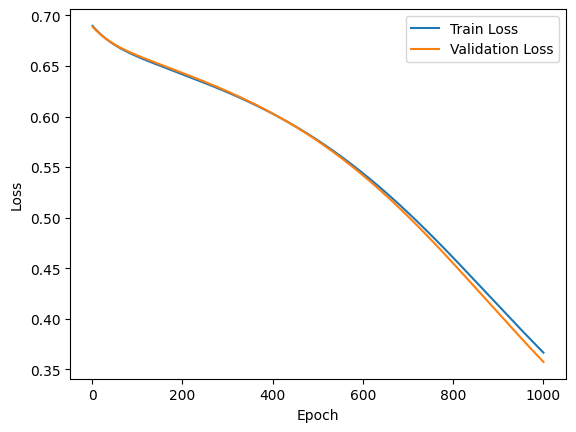

In [157]:
# Now, we modify our original architecture and add another hidden layer for comparison
class Net2(nn.Module):
  """
  Simple 1 hidden layer neural net
  """

  def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)
    self.fc3 = nn.Linear(hidden_size2, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return F.sigmoid(out)

# Input, hidden, and output sizes
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 256
output_size = 1

model = Net2(input_size, hidden_size1, hidden_size2, output_size)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

training_loop(1000, optimizer, model, loss_fn, X_train_tensor, X_test_tensor,
                  y_train_tensor, y_test_tensor)

In [156]:
# We can see above that adding more hidden layers has improved our model performance